In [44]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imodelsx.process_results
from collections import defaultdict
import numpy as np
import viz
import sys
sys.path.append('../experiments/')
results_dir = '/home/chansingh/mntv1/tree-prompt/aug22_vary_train_test'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
metric = 'roc_auc_test'
r['suffix'] = ''
r = r[r['model_name'] != 'manual_single_prompt']
r.loc[r['num_prompts'] == 1, 'model_name'] = 'single_prompt'
ks = ["dataset_name", "checkpoint", "checkpoint_evaluation", "model_name", 'prompt_source']
r = r[ks + [metric]].sort_values(by=ks)
r['dataset_name'] = r['dataset_name'].map(imodelsx.viz.DSETS_RENAME_DICT.get)
r['checkpoint'] = r['checkpoint'].map(imodelsx.viz.CHECKPOINTS_RENAME_DICT.get)
r['checkpoint_evaluation'] = r['checkpoint_evaluation'].map(imodelsx.viz.CHECKPOINTS_RENAME_DICT.get)
r['model_name'] = r['model_name'].map(imodelsx.viz.MODELS_RENAME_DICT.get)
r = r[r.prompt_source == 'manual']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 486/486 [00:38<00:00, 12.49it/s]


In [45]:
# # display all rows
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(r)

In [46]:
r = r[
    ~(
        r["checkpoint"].str.contains("llama", case=False)
        | r["checkpoint_evaluation"].str.contains("llama", case=False)
        | (r["dataset_name"] == "IMDB") # | (r["dataset_name"] == "Rotten tomatoes")
    )
]

In [47]:
group_without_dset = [k for k in ks if not k == 'dataset_name']
groups = r.groupby(group_without_dset)[metric]
means = groups.mean().reset_index()
# means

In [48]:
print('Did all models run for all datasets? If not then we need to finish the experiments with lower batch sizes.')
groups.count()

Did all models run for all datasets? If not then we need to finish the experiments with lower batch sizes.


checkpoint    checkpoint_evaluation  model_name         prompt_source
GPT-2 (1.5B)  GPT-2 (1.5B)           Single prompt      manual           4
                                     TreePrompt         manual           4
                                     TreePrompt (GBDT)  manual           4
              GPT-2 (117M)           Single prompt      manual           4
                                     TreePrompt         manual           4
                                                                        ..
GPT-J (6B)    GPT-2 (762M)           TreePrompt         manual           4
                                     TreePrompt (GBDT)  manual           4
              GPT-J (6B)             Single prompt      manual           8
                                     TreePrompt         manual           8
                                     TreePrompt (GBDT)  manual           8
Name: roc_auc_test, Length: 75, dtype: int64

In [49]:
means_all = means.pivot_table(
    index=["checkpoint", "model_name"], columns="checkpoint_evaluation", values=metric
)
vmin = means_all.min().min()
vmax = means_all.max().max()
means_all.style.format("{:.2f}").background_gradient(cmap="Blues")

# Visualize

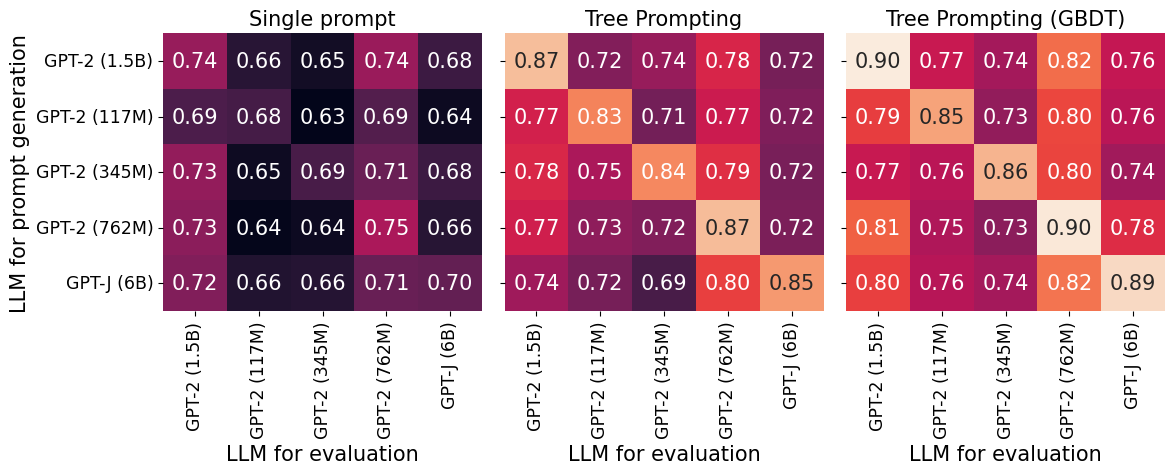

In [78]:
order = ["GPT-2 (117M)", "GPT-2 (345M)", "GPT-2 (762M)", "GPT-2 (1.5B)", "GPT-J (6B)"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, mod_name in enumerate(means["model_name"].unique()):
    # plt.subplot(1 ,3, i+1)
    sns.heatmap(
        means[means["model_name"] == mod_name].pivot_table(
            index=["checkpoint"], columns="checkpoint_evaluation", values=metric
        ),
        vmin=vmin,
        vmax=vmax,
        annot=True,
        ax=axes[i],
        cbar=False,
        fmt=".2f",
        # .loc[order, order]
        # .style.format("{:.2f}")
        # .background_gradient(cmap="viridis", axis=None, vmin=vmin, vmax=vmax)
    )
    if i > 0:
        axes[i].set_ylabel("")
        axes[i].set_yticklabels([])
    else:
        axes[i].set_ylabel("LLM for prompt generation")
    axes[i].set_xlabel("LLM for evaluation")
    # set ytick fontsize small
    axes[i].tick_params(which='major', labelsize='small')
    axes[i].set_title(mod_name.replace('TreePrompt', 'Tree Prompting'), fontsize='medium')
    # plt.show()
    plt.savefig('vary_train_test.pdf', bbox_inches='tight')

In [50]:
mod_name = "single prompt"
order = ["GPT-2 (117M)", "GPT-2 (345M)", "GPT-2 (762M)", "GPT-2 (1.5B)", "GPT-J (6B)"]
for mod_name in means["model_name"].unique():
    print(mod_name)
    display(
        means[means["model_name"] == mod_name]
        .pivot_table(
            index=["checkpoint"], columns="checkpoint_evaluation", values=metric
        )
        .loc[order, order]
        .style.format("{:.2f}")
        .background_gradient(cmap="viridis", axis=None, vmin=vmin, vmax=vmax)
    )

Single prompt


checkpoint_evaluation,GPT-2 (117M),GPT-2 (345M),GPT-2 (762M),GPT-2 (1.5B),GPT-J (6B)
checkpoint,,,,,
GPT-2 (117M),0.68,0.63,0.69,0.69,0.64
GPT-2 (345M),0.65,0.69,0.71,0.73,0.68
GPT-2 (762M),0.64,0.64,0.75,0.73,0.66
GPT-2 (1.5B),0.66,0.65,0.74,0.74,0.68
GPT-J (6B),0.66,0.66,0.71,0.72,0.70


TreePrompt


checkpoint_evaluation,GPT-2 (117M),GPT-2 (345M),GPT-2 (762M),GPT-2 (1.5B),GPT-J (6B)
checkpoint,,,,,
GPT-2 (117M),0.83,0.71,0.77,0.77,0.72
GPT-2 (345M),0.75,0.84,0.79,0.78,0.72
GPT-2 (762M),0.73,0.72,0.87,0.77,0.72
GPT-2 (1.5B),0.72,0.74,0.78,0.87,0.72
GPT-J (6B),0.72,0.69,0.80,0.74,0.85


TreePrompt (GBDT)


checkpoint_evaluation,GPT-2 (117M),GPT-2 (345M),GPT-2 (762M),GPT-2 (1.5B),GPT-J (6B)
checkpoint,,,,,
GPT-2 (117M),0.85,0.73,0.80,0.79,0.76
GPT-2 (345M),0.76,0.86,0.80,0.77,0.74
GPT-2 (762M),0.75,0.73,0.90,0.81,0.78
GPT-2 (1.5B),0.77,0.74,0.82,0.90,0.76
GPT-J (6B),0.76,0.74,0.82,0.80,0.89


In [51]:
mod_name = "single prompt"
order = ["GPT-2 (117M)", "GPT-2 (345M)", "GPT-2 (762M)", "GPT-2 (1.5B)", "GPT-J (6B)"]
for mod_name in means["model_name"].unique():
    print(mod_name)
    # display(
    print(
        means[means["model_name"] == mod_name]
        .pivot_table(
            index=["checkpoint"], columns="checkpoint_evaluation", values=metric
        )
        .loc[order, order]
        .to_markdown()
        # .style.format("{:.2f}")
        # .background_gradient(cmap="viridis", axis=None, vmin=vmin, vmax=vmax)
    )

Single prompt
| checkpoint   |   GPT-2 (117M) |   GPT-2 (345M) |   GPT-2 (762M) |   GPT-2 (1.5B) |   GPT-J (6B) |
|:-------------|---------------:|---------------:|---------------:|---------------:|-------------:|
| GPT-2 (117M) |       0.68349  |       0.634993 |       0.693089 |       0.688544 |     0.643457 |
| GPT-2 (345M) |       0.645217 |       0.685511 |       0.707314 |       0.733435 |     0.677181 |
| GPT-2 (762M) |       0.638012 |       0.643481 |       0.748391 |       0.728508 |     0.663196 |
| GPT-2 (1.5B) |       0.663258 |       0.648455 |       0.737763 |       0.735755 |     0.677171 |
| GPT-J (6B)   |       0.658212 |       0.662086 |       0.706921 |       0.722314 |     0.703473 |
TreePrompt
| checkpoint   |   GPT-2 (117M) |   GPT-2 (345M) |   GPT-2 (762M) |   GPT-2 (1.5B) |   GPT-J (6B) |
|:-------------|---------------:|---------------:|---------------:|---------------:|-------------:|
| GPT-2 (117M) |       0.833168 |       0.714309 |       0.769057 |       0